<a href="https://colab.research.google.com/github/yasanthinadun/Assignment-2/blob/main/Assessment_2_CNNs_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
# Import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
# Downloading the dataset
dataset = CIFAR100(root = 'data/', download = True, transform = ToTensor())
test_dataset = CIFAR100(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [29]:
# Length of the training and the test datasets
print(len(dataset))
print(len(test_dataset))

50000
10000


In [30]:
# Names of classes
classes = dataset.classes
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [31]:
#shape of the image tensor
img, label = dataset[31]
img_shape = img.shape
img_shape

torch.Size([3, 32, 32])

In [32]:
# for reproducibility set manual_seed
torch.manual_seed(43) # for reproducibility
val_size = 10000
train_size = len(dataset) - val_size

In [33]:
# Random Split and Split of dataset between train and validation
train_ds, val_ds = random_split(dataset,[train_size, val_size])
len(train_ds), len(val_ds)

(40000, 10000)

In [34]:
#Batch Size
batch_size = 128

In [35]:
# Defininf Loaders for training process
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers=4, pin_memory =True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory =True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory =True)

Shape of an Image (Batch Size, RGB, Pixels): torch.Size([128, 3, 32, 32])


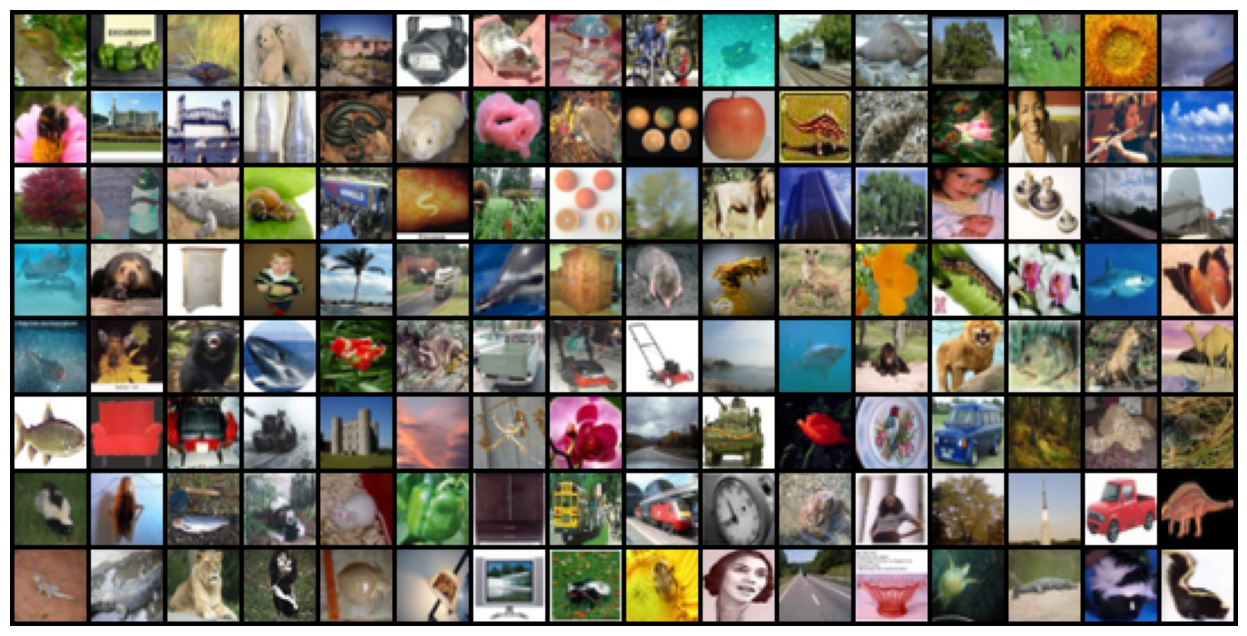

In [36]:
# Visualization of batch grid
for images, _ in train_loader:
    print('Shape of an Image (Batch Size, RGB, Pixels):', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [37]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [41]:
# Defining the base of the models with common procedures
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

**Convolutional Neural Network (CNN)**

In [42]:
#Create the Convolutional Neural Network (CNN) structure

class Cifar100CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 100))

    def forward(self, xb):
        return self.network(xb)

In [43]:
# fit and evaluation functions for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [44]:
model_cnn =  to_device(Cifar100CnnModel(), device)
model_cnn

Cifar100CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_fea

In [45]:
# Initial results before training:
history_cnn = [evaluate(model_cnn, val_loader)]
history_cnn

[{'val_loss': 4.6059184074401855, 'val_acc': 0.008801423944532871}]

In [46]:
# Model hyperparameters and optimizer:
num_epochs_cnn = [10, 5]
opt_func = torch.optim.Adam #now we change also the optimizer
lr_cnn = [1e-3, 1e-4]

In [47]:
%%time
history_cnn += fit(num_epochs_cnn[0], lr_cnn[0], model_cnn, train_loader, val_loader, opt_func)

Epoch [0], val_loss: 4.0131, val_acc: 0.0581
Epoch [1], val_loss: 3.6735, val_acc: 0.1236
Epoch [2], val_loss: 3.3933, val_acc: 0.1693
Epoch [3], val_loss: 3.2351, val_acc: 0.2067
Epoch [4], val_loss: 3.0379, val_acc: 0.2430
Epoch [5], val_loss: 2.8972, val_acc: 0.2820
Epoch [6], val_loss: 2.7707, val_acc: 0.3080
Epoch [7], val_loss: 2.7065, val_acc: 0.3214
Epoch [8], val_loss: 2.6728, val_acc: 0.3322
Epoch [9], val_loss: 2.7159, val_acc: 0.3424
CPU times: user 31.2 s, sys: 10.6 s, total: 41.8 s
Wall time: 1min 38s


In [48]:
%%time
history_cnn += fit(num_epochs_cnn[1], lr_cnn[1], model_cnn, train_loader, val_loader, opt_func)

Epoch [0], val_loss: 2.7502, val_acc: 0.3576
Epoch [1], val_loss: 2.7807, val_acc: 0.3602
Epoch [2], val_loss: 2.8176, val_acc: 0.3586
Epoch [3], val_loss: 2.8616, val_acc: 0.3573
Epoch [4], val_loss: 2.9161, val_acc: 0.3551
CPU times: user 15.1 s, sys: 4.75 s, total: 19.8 s
Wall time: 49.4 s


In [49]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs');

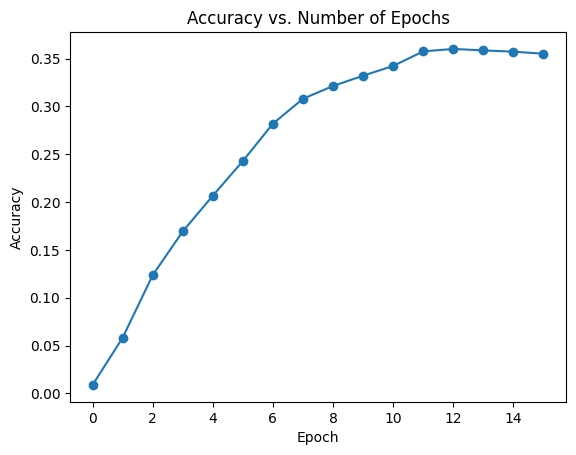

In [50]:
#Plot Accuracy of the model:
plot_accuracies(history_cnn)

In [51]:
# plot losses of the model
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

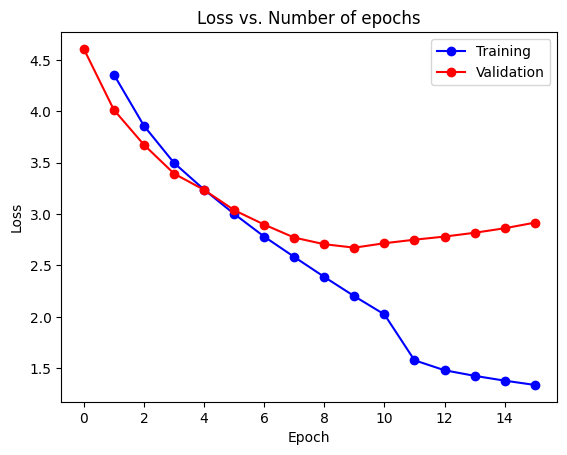

In [52]:
plot_losses(history_cnn)

In [53]:
# evaluation of the CNN Model with the test dataset:
test_cnn = evaluate(model_cnn, test_loader) #final evaluation of cnn model with test dataset
test_cnn

{'val_loss': 2.907336950302124, 'val_acc': 0.366594135761261}

In [54]:
test_loss_cnn = test_cnn['val_loss']
test_acc_cnn = test_cnn['val_acc']
print('test_loss_cnn:', test_cnn['val_loss'])
print('test_acc_cnn:', test_cnn['val_acc'])

test_loss_cnn: 2.907336950302124
test_acc_cnn: 0.366594135761261


In [55]:
torch.save(model_cnn.state_dict(), 'cnn.pth')

In [56]:
input_size = (3, 32, 32)
summary(model_cnn,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

**ResNet9 Model**

In [58]:
# Create ResNet9 Model structure

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [59]:
# helper function with Batch Normalization method applied
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [60]:
# evaluate and fit functions are defined
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [61]:
model_resnet9 = to_device(ResNet9(3, 100), device)
model_resnet9

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [62]:
history_resnet9 = [evaluate(model_resnet9, val_loader)]
history_resnet9

[{'val_loss': 4.605964660644531, 'val_acc': 0.007021360564976931}]

In [63]:
# Define hyperparameters, Optimizer, Weight Decay and optimiser
epochs_resnet9 = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [64]:
%%time
history_resnet9 += fit_one_cycle(epochs_resnet9, max_lr, model_resnet9, train_loader, val_loader,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00152, train_loss: 3.5372, val_loss: 3.6154, val_acc: 0.1935
Epoch [1], last_lr: 0.00436, train_loss: 2.8567, val_loss: 3.0938, val_acc: 0.2684
Epoch [2], last_lr: 0.00760, train_loss: 2.2676, val_loss: 2.7190, val_acc: 0.3357
Epoch [3], last_lr: 0.00971, train_loss: 1.7622, val_loss: 2.3457, val_acc: 0.3910
Epoch [4], last_lr: 0.00994, train_loss: 1.4311, val_loss: 2.4040, val_acc: 0.4153
Epoch [5], last_lr: 0.00950, train_loss: 1.1181, val_loss: 1.9213, val_acc: 0.5012
Epoch [6], last_lr: 0.00867, train_loss: 0.8370, val_loss: 1.9054, val_acc: 0.5228
Epoch [7], last_lr: 0.00750, train_loss: 0.5548, val_loss: 2.0126, val_acc: 0.5341
Epoch [8], last_lr: 0.00611, train_loss: 0.2960, val_loss: 2.2590, val_acc: 0.5474
Epoch [9], last_lr: 0.00463, train_loss: 0.1255, val_loss: 1.8842, val_acc: 0.6059
Epoch [10], last_lr: 0.00317, train_loss: 0.0421, val_loss: 1.7814, val_acc: 0.6327
Epoch [11], last_lr: 0.00188, train_loss: 0.0101, val_loss: 1.7365, val_acc: 0.6443
Ep

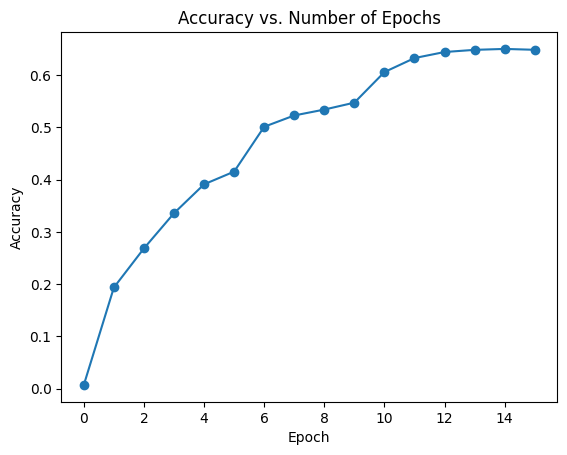

In [65]:
# plot accuracy of the model
plot_accuracies(history_resnet9)

In [66]:
# plot losses of the model
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bo')
    plt.plot(val_losses, '-ro')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. Number of epochs');

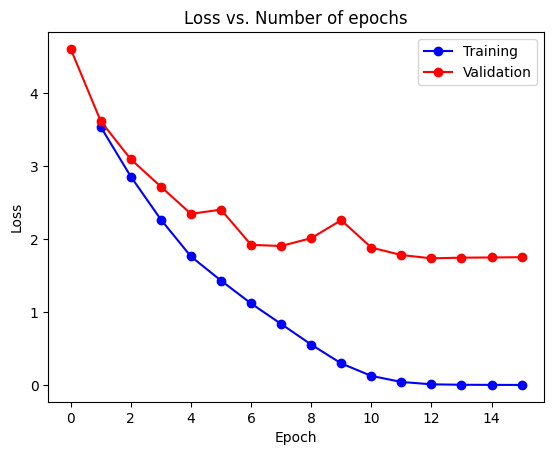

In [67]:
plot_losses(history_resnet9)

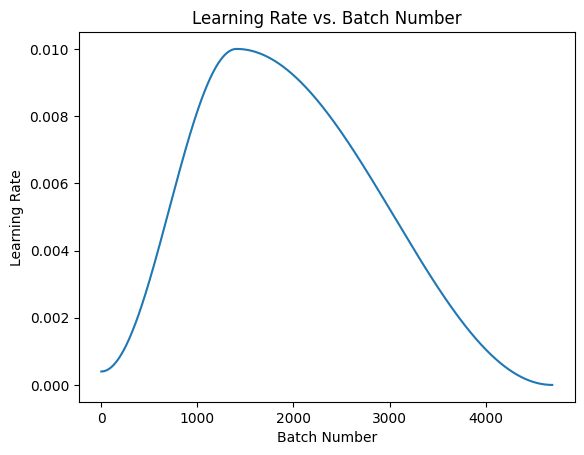

In [72]:
# plot movement of learning rates over time
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch Number')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate vs. Batch Number');
plot_lrs(history_resnet9)

In [73]:
#evaluation of resnet9 model with test dataset
test_resnet9 = evaluate(model_resnet9, test_loader) #final evaluation of resnet9 model with test dataset
test_resnet9

{'val_loss': 1.708085536956787, 'val_acc': 0.6525909900665283}

In [74]:
test_loss_resnet9 = test_resnet9['val_loss']
test_acc_resnet9 = test_resnet9['val_acc']
print('test_loss_resnet9:', test_resnet9['val_loss'])
print('test_acc_resnet9:', test_resnet9['val_acc'])

test_loss_resnet9: 1.708085536956787
test_acc_resnet9: 0.6525909900665283


In [75]:
torch.save(model_resnet9.state_dict(), 'ResNet9.pth')

In [76]:
summary(model_resnet9,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

**VGG Model**

In [77]:
# Define VGG model structure
class VGGModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.features = self._make_layers()
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self):
        layers = []
        in_channels = 3
        cfg = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1),
                           nn.BatchNorm2d(v),
                           nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [78]:
# Create the VGG model and move it to the GPU
model_vgg = to_device(VGGModel(100), device)

# Define hyperparameters for training the VGG model
epochs_vgg = 15
max_lr_vgg = 0.01
grad_clip_vgg = 0.1
weight_decay_vgg = 1e-5
opt_func_vgg = torch.optim.Adam


In [79]:
# Train the VGG model
history_vgg = [evaluate(model_vgg, val_loader)]
history_vgg += fit_one_cycle(epochs_vgg, max_lr_vgg, model_vgg, train_loader, val_loader,
                             grad_clip=grad_clip_vgg, weight_decay=weight_decay_vgg, opt_func=opt_func_vgg)


Epoch [0], last_lr: 0.00152, train_loss: 4.1970, val_loss: 3.9883, val_acc: 0.0685
Epoch [1], last_lr: 0.00436, train_loss: 3.8936, val_loss: 4.1899, val_acc: 0.0624
Epoch [2], last_lr: 0.00760, train_loss: 3.7445, val_loss: 4.3132, val_acc: 0.0603
Epoch [3], last_lr: 0.00971, train_loss: 3.6075, val_loss: 3.6901, val_acc: 0.1103
Epoch [4], last_lr: 0.00994, train_loss: 3.4950, val_loss: 3.5059, val_acc: 0.1499
Epoch [5], last_lr: 0.00950, train_loss: 3.3633, val_loss: 3.4488, val_acc: 0.1480
Epoch [6], last_lr: 0.00867, train_loss: 3.1978, val_loss: 3.1623, val_acc: 0.1911
Epoch [7], last_lr: 0.00750, train_loss: 3.0423, val_loss: 2.9287, val_acc: 0.2451
Epoch [8], last_lr: 0.00611, train_loss: 3.0040, val_loss: 3.5786, val_acc: 0.1856
Epoch [9], last_lr: 0.00463, train_loss: 2.7401, val_loss: 2.7012, val_acc: 0.2916
Epoch [10], last_lr: 0.00317, train_loss: 2.4200, val_loss: 2.7431, val_acc: 0.3066
Epoch [11], last_lr: 0.00188, train_loss: 2.1424, val_loss: 2.3696, val_acc: 0.3641
Ep

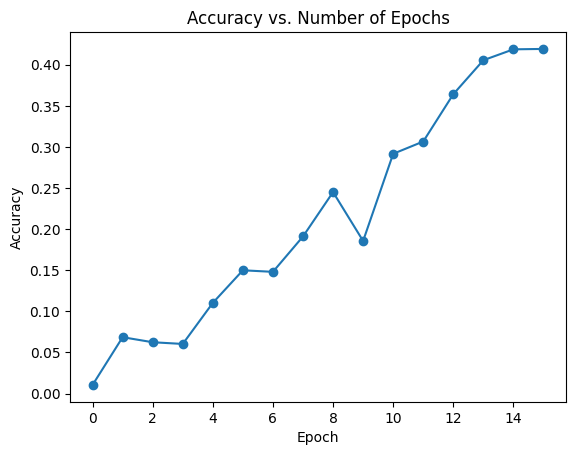

In [80]:
# Plot the accuracy and loss for the VGG model
plot_accuracies(history_vgg)


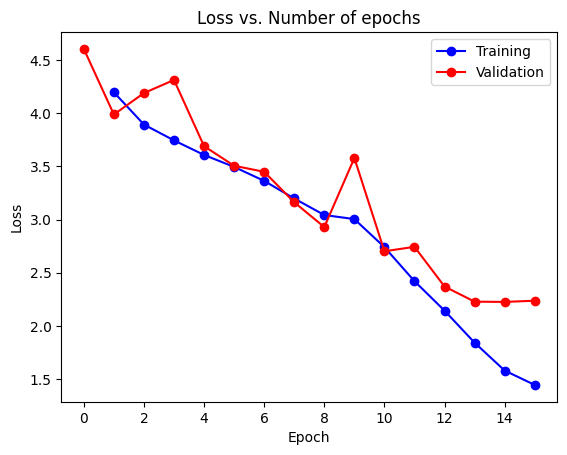

In [81]:
plot_losses(history_vgg)


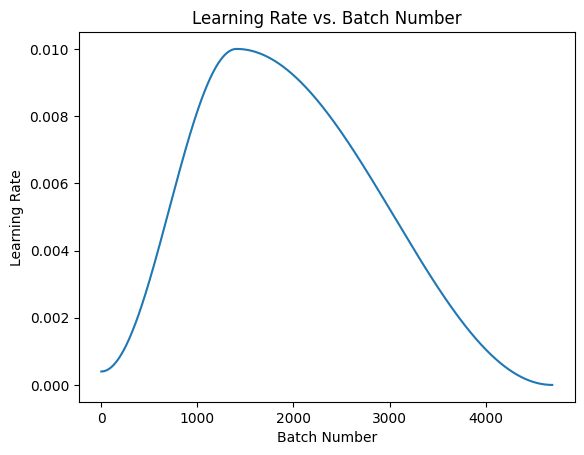

In [82]:
plot_lrs(history_vgg)

In [83]:
# Evaluate the VGG model on the test dataset
test_vgg = evaluate(model_vgg, test_loader)
test_loss_vgg = test_vgg['val_loss']
test_acc_vgg = test_vgg['val_acc']
print('Test Loss (VGG):', test_loss_vgg)
print('Test Accuracy (VGG):', test_acc_vgg)

Test Loss (VGG): 2.1779072284698486
Test Accuracy (VGG): 0.4391811788082123


In [84]:
# Save the VGG model's weights
torch.save(model_vgg.state_dict(), 'VGGModel.pth')

In [85]:
summary(model_vgg,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
           Conv2d-12            [-1, 256, 8, 8]         590,080
      BatchNorm2d-13            [-1, 256, 8, 8]             512
             ReLU-14            [-1, 25

**LeNet Model**

In [86]:
# Define LeNet Model Structure
class LeNet(ImageClassificationBase):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [87]:
# Create the LeNet model and move it to the GPU
model_lenet = to_device(LeNet(100), device)

# Evaluate the LeNet model on the validation set before training
history_lenet = [evaluate(model_lenet, val_loader)]

In [88]:
# Define the number of epochs, learning rate, and other training parameters
epochs_lenet = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam


In [89]:
# Train the LeNet model
history_lenet += fit_one_cycle(epochs_lenet, max_lr, model_lenet, train_loader, val_loader,
                               grad_clip=grad_clip, weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00152, train_loss: 4.3788, val_loss: 4.0708, val_acc: 0.0724
Epoch [1], last_lr: 0.00436, train_loss: 3.9581, val_loss: 3.8186, val_acc: 0.1076
Epoch [2], last_lr: 0.00760, train_loss: 3.7463, val_loss: 3.6781, val_acc: 0.1366
Epoch [3], last_lr: 0.00971, train_loss: 3.6801, val_loss: 3.8621, val_acc: 0.1084
Epoch [4], last_lr: 0.00994, train_loss: 3.6411, val_loss: 3.6417, val_acc: 0.1408
Epoch [5], last_lr: 0.00950, train_loss: 3.5465, val_loss: 3.6262, val_acc: 0.1470
Epoch [6], last_lr: 0.00867, train_loss: 3.4384, val_loss: 3.4606, val_acc: 0.1807
Epoch [7], last_lr: 0.00750, train_loss: 3.3516, val_loss: 3.5832, val_acc: 0.1695
Epoch [8], last_lr: 0.00611, train_loss: 3.2362, val_loss: 3.4435, val_acc: 0.1775
Epoch [9], last_lr: 0.00463, train_loss: 3.1163, val_loss: 3.3004, val_acc: 0.2035
Epoch [10], last_lr: 0.00317, train_loss: 2.9865, val_loss: 3.2466, val_acc: 0.2207
Epoch [11], last_lr: 0.00188, train_loss: 2.8343, val_loss: 3.2256, val_acc: 0.2338
Ep

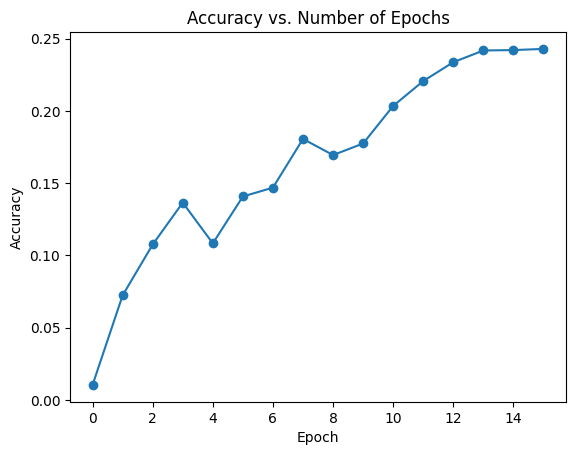

In [90]:
# Plot accuracy and losses
plot_accuracies(history_lenet)

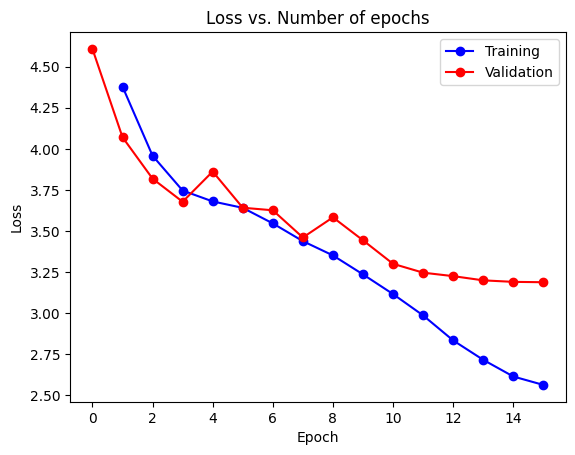

In [91]:
plot_losses(history_lenet)

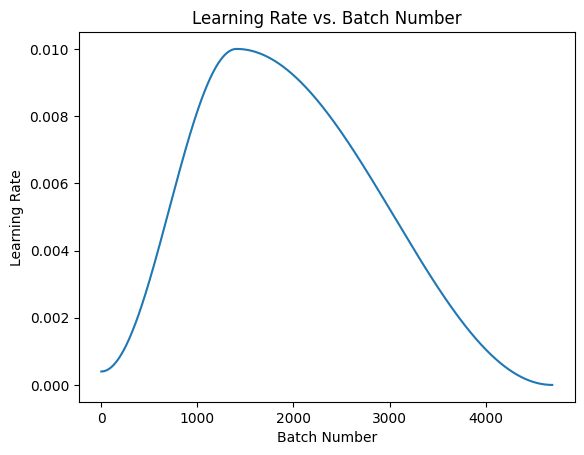

In [92]:
plot_lrs(history_lenet)

In [93]:
# Evaluate the LeNet model on the test set
test_lenet = evaluate(model_lenet, test_loader)

In [94]:
# Get test loss and accuracy
test_loss_lenet = test_lenet['val_loss']
test_acc_lenet = test_lenet['val_acc']

print('Test Loss (LeNet):', test_loss_lenet)
print('Test Accuracy (LeNet):', test_acc_lenet)

Test Loss (LeNet): 3.189779043197632
Test Accuracy (LeNet): 0.2460443079471588


In [95]:
# Save the LeNet model's weights
torch.save(model_lenet.state_dict(), 'LeNet.pth')

In [96]:
summary(model_lenet,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                  [-1, 100]           8,500
Total params: 69,656
Trainable params: 69,656
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba